In [1]:
import math
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.special import rel_entr



In [2]:
def myround(x, base=5):
    return base * round(x/base)

In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [4]:
def hellinger_explicit(p, q):
    """Hellinger distance between two discrete distributions.
       Same as original version but without list comprehension

    Args:
        p, q: two discrete probability distributions

    Returns:
        Hellinger distance between p and q. This is distributed between 0 and 1.
    """
    p = np.array(p) # these need to be probablility distributions
    q = np.array(q)

    list_of_squares = []
    #for p_i, q_i in zip(p, q):

    # caluclate the square of the difference of ith distr elements
    s = (np.sqrt(p) - np.sqrt(q)) ** 2

    # calculate sum of squares
    sosq = sum(s)

    return np.sqrt(sosq) / math.sqrt(2)

In [5]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [6]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [7]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [8]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'Proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.show()
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    #plt.close()

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


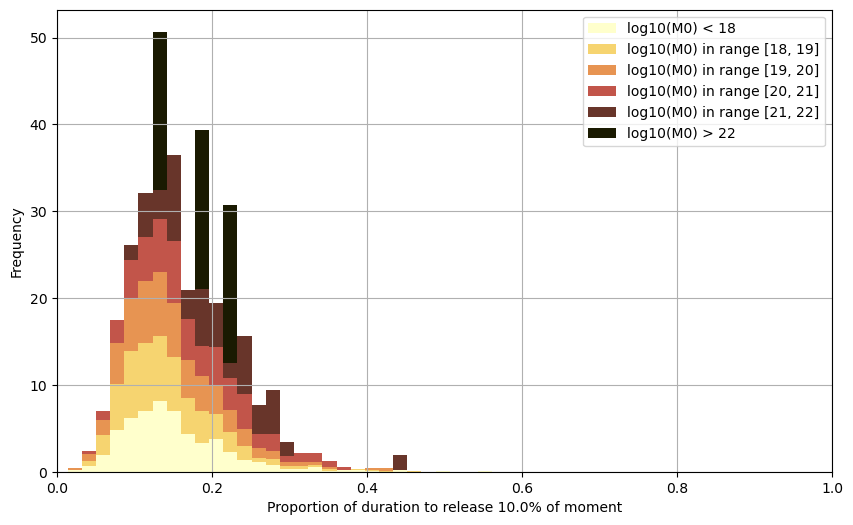

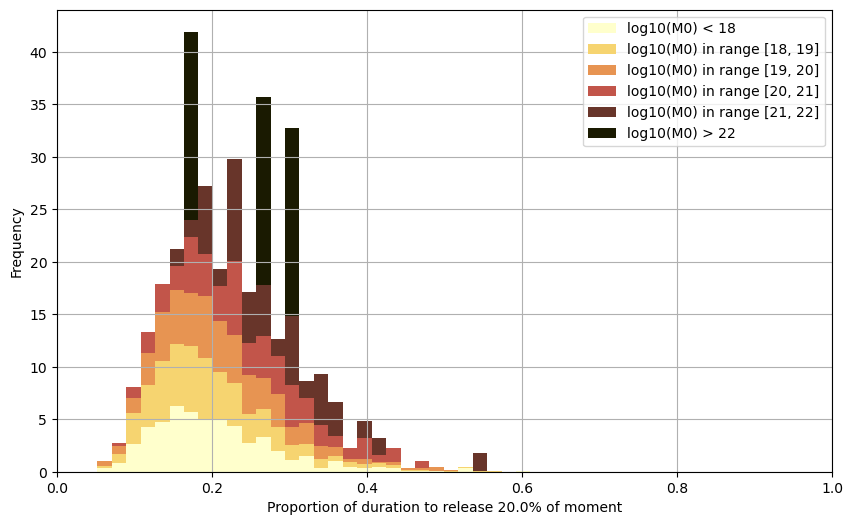

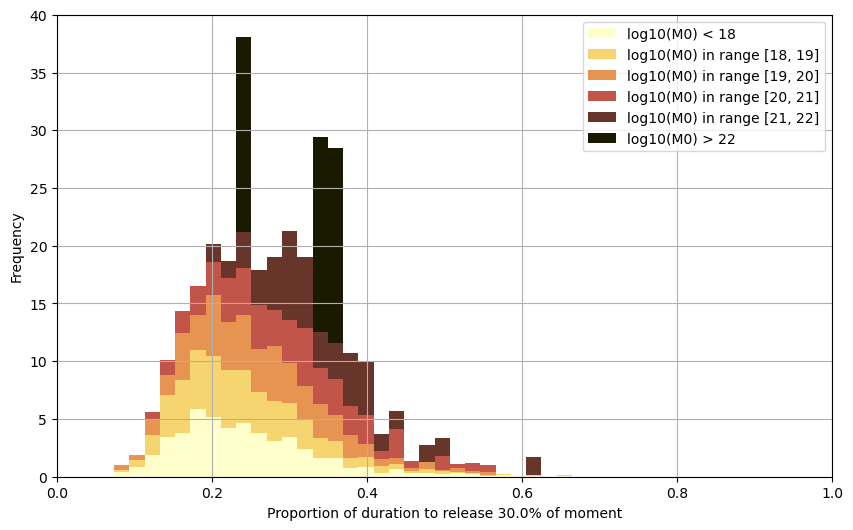

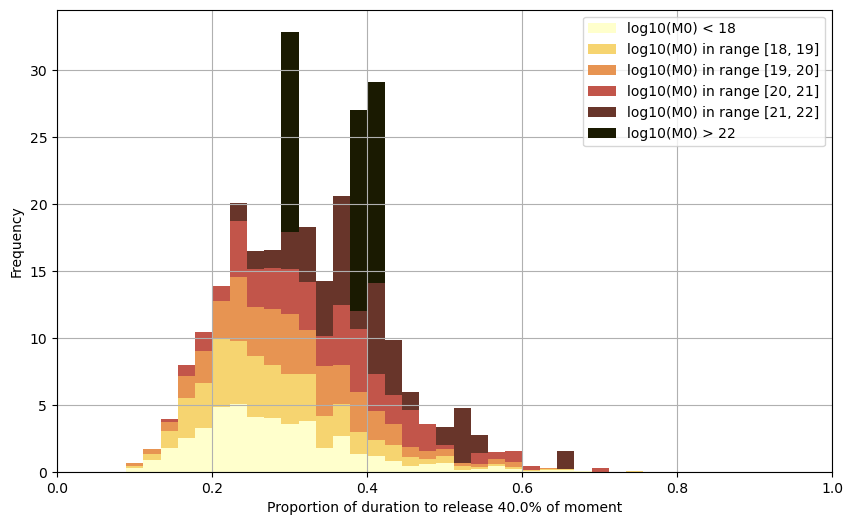

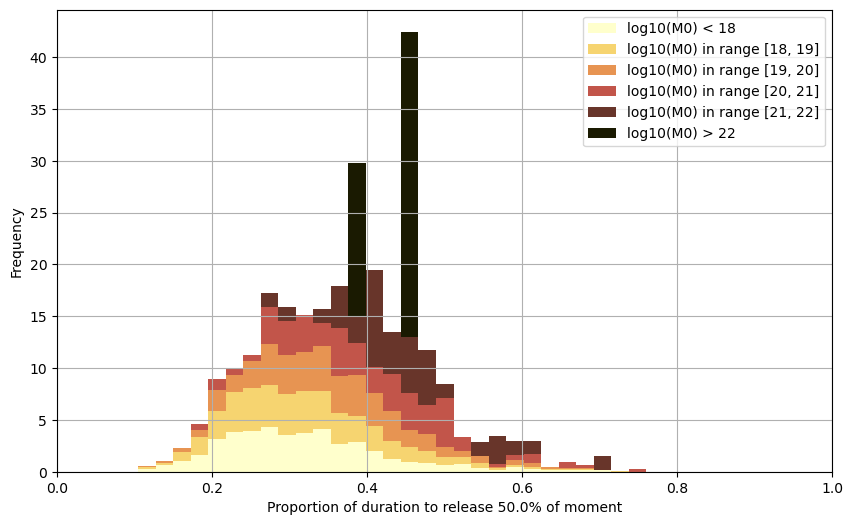

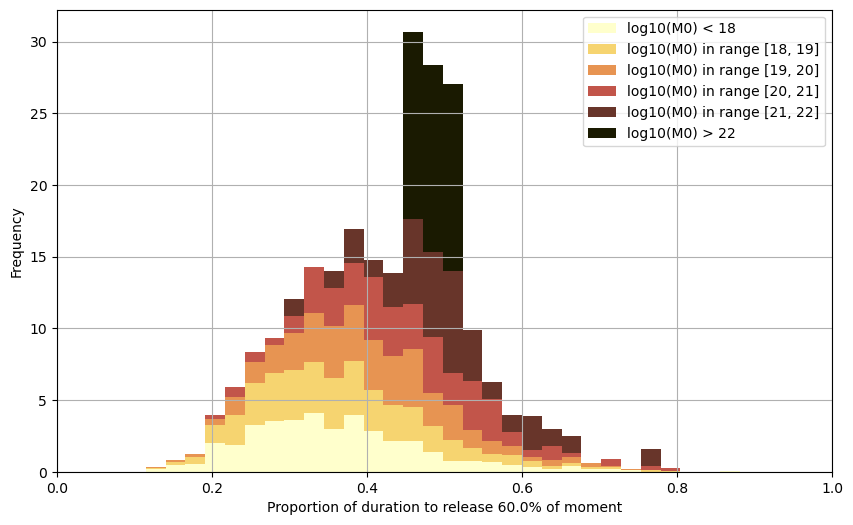

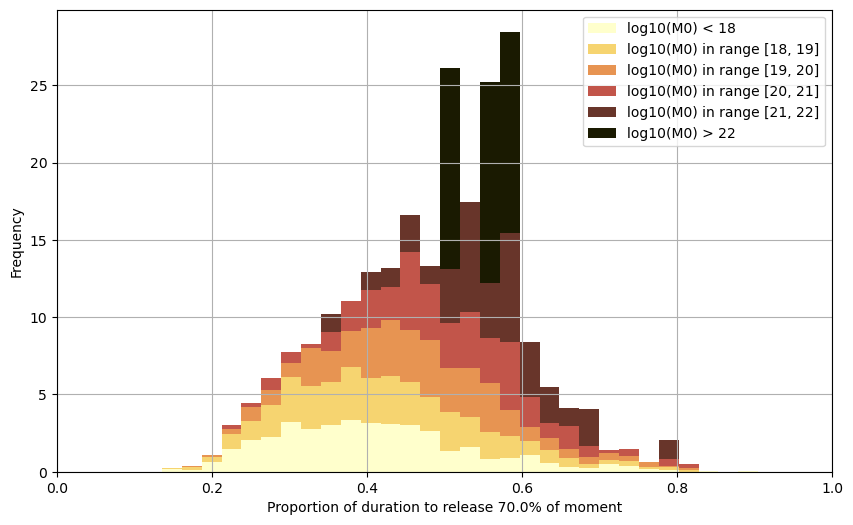

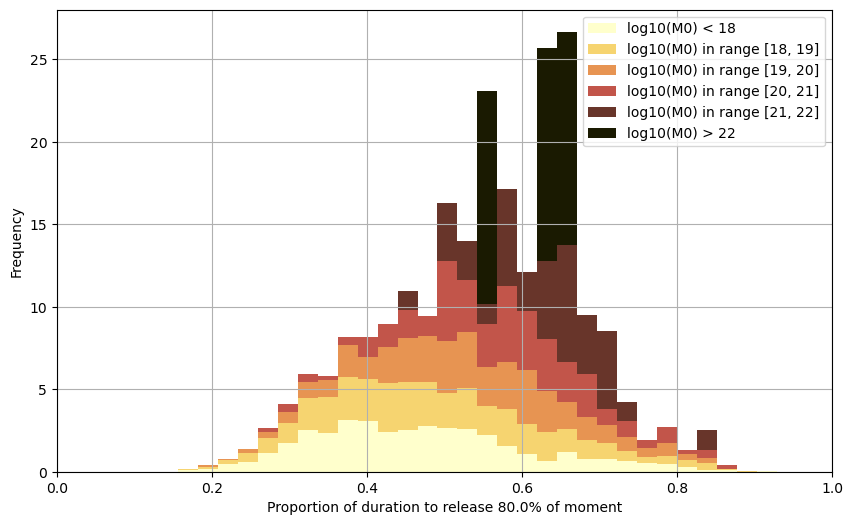

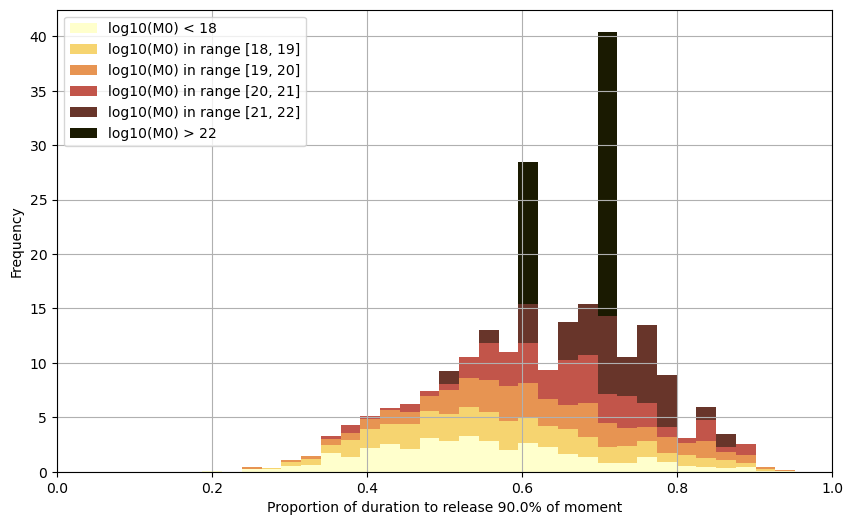

In [9]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

for proportion in proportions_list:
    print(proportion)
    durations = []
    root_times = []
    relative_root_times = []

    diff = []
    moments = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        #print(scardec_name)
        momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type='fctmoy')

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        root_times.append(root_time)
        relative_root_times.append(root_time-start_time)

        if root_time-start_time > duration:
            print('root time greater than duration, proportion:', proportion)
            print(scardec_name)

    root_times = np.array(root_times)
    durations = np.array(durations)
    moments = np.log10(np.array(moments))

    rel_root_times = root_times/durations

#    plt.hist([rel_root_times[np.where((moments > 18) & (moments < 19))[0]]])
    t_18 = rel_root_times[np.where((moments < 18))[0]]
    t_18_19 = rel_root_times[np.where((moments > 18) & (moments < 19))[0]]
    t_19_20 = rel_root_times[np.where((moments > 19) & (moments < 20))[0]]
    t_20_21 = rel_root_times[np.where((moments > 20) & (moments < 21))[0]]
    t_21_22 = rel_root_times[np.where((moments > 21) & (moments < 22))[0]]
    t_22 = rel_root_times[np.where((moments > 22))[0]]

    columns = ['log10(M0) < 18',
               'log10(M0) in range [18, 19]',
                'log10(M0) in range [19, 20]',
                'log10(M0) in range [20, 21]',
                'log10(M0) in range [21, 22]',
                'log10(M0) > 22']
    df = pd.concat([pd.DataFrame(a, columns=[f'{i}, log10(M0) in range [{i+17}, {i+18}]']) for i, a in enumerate([t_18, t_18_19, t_19_20, t_20_21, t_21_22, t_22])], axis=1)
    df.columns = columns

    df.plot.hist(stacked=True, bins=30, density=True, figsize=(10, 6), grid=True, colormap = cmc.lajolla)

    plt.ylabel('Frequency')
    plt.xlabel(f'Proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/stacked_histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')

In [10]:
#proportions_list = [0.4, 0.6]
all_proportions = [[0.45, 0.55], [0.4, 0.6], [0.35, 0.65], [0.3, 0.7], [0.25, 0.75], [0.2, 0.8], [0.15, 0.85], [0.1, 0.9], [0.05, 0.95]]
all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []
for proportions_list in all_proportions:
    for proportion in proportions_list:
        print(proportion)
        durations = []
        root_times = []
        relative_root_times = []

        diff = []
        moments = []

        for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
            #print(scardec_name)
            momentrate_opt, time_opt, db = get_stf(scardec_name)

            not_zero = np.where(momentrate_opt > 0)[0]

            dx = time_opt[1]-time_opt[0]

            start = min(not_zero)
            end = max(not_zero)
            points_before_zero = abs(min(time_opt)/dx)

            duration = time_opt[end] - time_opt[start]
            durations.append(duration)

            start_time = time_opt[start]
            end_time = time_opt[end]

            total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
            moments.append(total_moment)
            root, r = scipy.optimize.bisect(f3,
                                            start_time+dx,
                                            end_time,
                                            rtol = 1e-6,
                                            full_output = True,
                                            args = (total_moment,
                                                    time_opt,
                                                    momentrate_opt,
                                                    start,
                                                    points_before_zero,
                                                    proportion,))
            root_idx = np.floor(root/dx)
            root_time = root_idx*dx
            root_times.append(root_time)
            relative_root_times.append(root_time-start_time)

            if root_time-start_time > duration:
                print('root time greater than duration, proportion:', proportion)
                print(scardec_name)

        root_times = np.array(root_times)
        durations = np.array(durations)
        moments = np.log10(np.array(moments))

        rel_root_times = root_times/durations
        rel_root_times = scipy.special.logit(rel_root_times)

        n, bins = np.histogram(rel_root_times, bins=np.arange(-10, 10, 0.1))

        if proportion < 0.5:
            P = n/sum(n)
            #plt.stairs(n/sum(n), bins, label = f'{proportion*100:.0f}%')
        else:
            Q = (n/sum(n))[::-1]
            #plt.stairs((n/sum(n)), bins, label = f'{proportion*100:.0f}%')
            #plt.stairs((n/sum(n))[::-1], bins, label = f'{proportion*100:.0f}%')
        plt.ylabel('Frequency')
        plt.xlabel('Proportion of duration to release proportion of moment')
        #plt.xscale('logit')
        #plt.xlim(0, 1)

        if proportion > 0.5:
            tf = (P != 0) & (Q != 0)
            z_p = np.zeros(len(bins)-1)
            z_q = np.zeros(len(bins)-1)
            z_p[tf] = P[tf]
            z_q[tf] = Q[tf]
            plt.stairs(P, bins, linestyle = '--', color = 'tab:blue')
            plt.stairs(Q, bins, linestyle = '--', color = 'tab:orange')
            plt.stairs(z_p, bins, color = 'tab:blue', label = f'P: {myround((1-proportion)*100):.0f}%')
            plt.stairs(z_q, bins, color = 'tab:orange', label = f'Q: {myround(proportion*100):.0f}%')
            KL = sum(rel_entr(P[tf], Q[tf]))
            print(KL)
            KL_2 = sum(rel_entr(Q[tf], P[tf]))
            print(KL_2)
            print(hellinger_explicit(P, Q))

            plt.title(f'KL(P||Q): {KL:.5f}, KL(Q||P): {KL_2:.5f} \n Hellinger distance: {hellinger_explicit(P, Q):.5f}')
            plt.legend()
            #plt.show()

    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/logit_transform/flipped_histogram_fraction_of_duration_for_{myround((1-proportion)*100)}_{myround(proportion*100)}_percent_moment.png')
    plt.close()

0.45
0.55
0.026633817325125965
0.025520813811282652
0.09380359539847999
0.4
0.6
0.03789051351419744
0.033444695506081305
0.10514743119376009
0.35
0.65
0.05054955262763426
0.04701404701438332
0.12148214616672177
0.3
0.7
0.0795711655134992
0.06851544919528994
0.1446256938167839
0.25
0.75
0.13643634198851262
0.117086364550349
0.18490131630865844
0.2
0.8
0.21965201353660468
0.18480331691663673
0.22954790320045293
0.15
0.85
0.37240346294683696
0.2950526651997075
0.29456619093630804
0.1
0.9
0.687403599335534
0.5041601103350544
0.3828183772494205
0.05
0.95
1.4134797114683695
1.0052326450091877
0.532172734451112


In [11]:
all_proportions = [[0.45, 0.55], [0.4, 0.6], [0.35, 0.65], [0.3, 0.7], [0.25, 0.75], [0.2, 0.8], [0.15, 0.85], [0.1, 0.9], [0.05, 0.95]]
all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []
for proportions_list in all_proportions:
    for proportion in proportions_list:
        print(f'{myround((1-proportion)*100)}_{myround(proportion*100)}')

55_45
45_55
60_40
40_60
65_35
35_65
70_30
30_70
75_25
25_75
80_20
20_80
85_15
15_85
90_10
10_90
95_5
5_95


In [12]:
def hellinger_explicit(p, q):
    """Hellinger distance between two discrete distributions.
       Same as original version but without list comprehension

    Args:
        p, q: two discrete probability distributions

    Returns:
        Hellinger distance between p and q. This is distributed between 0 and 1.
    """
    p = np.array(p) # these need to be probablility distributions
    q = np.array(q)

    list_of_squares = []
    #for p_i, q_i in zip(p, q):

    # caluclate the square of the difference of ith distr elements
    s = (np.sqrt(p) - np.sqrt(q)) ** 2

    # calculate sum of squares
    sosq = sum(s)

    return np.sqrt(sosq) / math.sqrt(2)

0.45
0.55
0.03307356314873483
0.034141453748715966
0.09946887757498125
0.04329745596868884


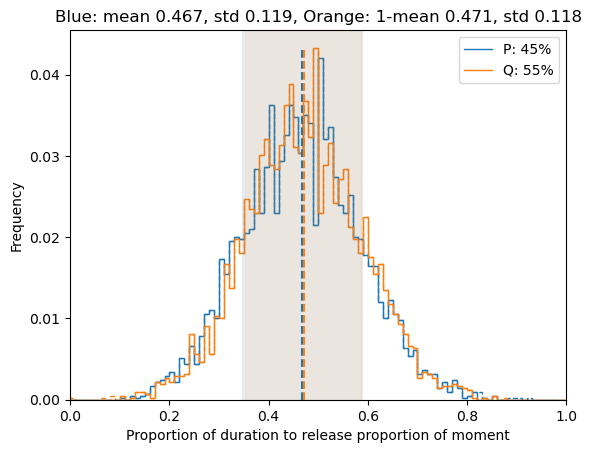

0.4
0.6
0.035487499867441014
0.034845151967502125
0.10143356696451955
0.04354207436399217


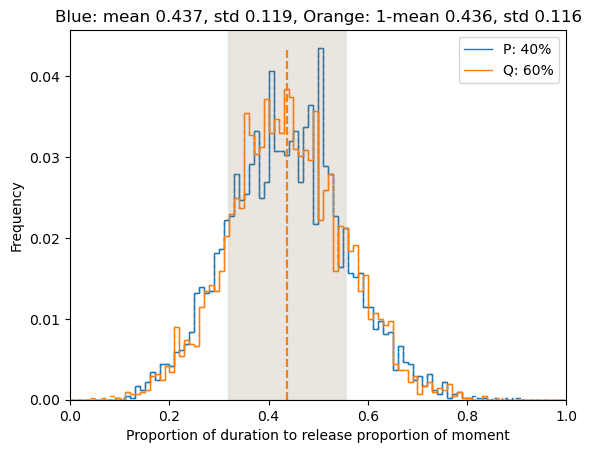

0.35
0.65
0.050349384111569785
0.04783168999568397
0.11580564739057193
0.040626529613313755


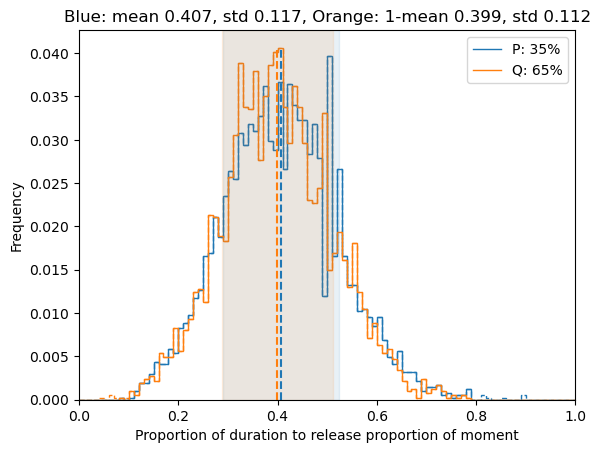

0.3
0.7
0.05333963228188395
0.04798471774061878
0.12038219410868292
0.04454233969652472


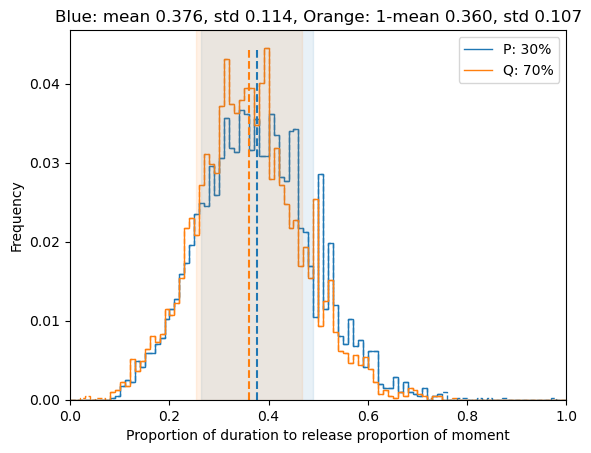

0.25
0.75
0.06656809865187253
0.058355893688687384
0.1342103269064571
0.0465230166503428


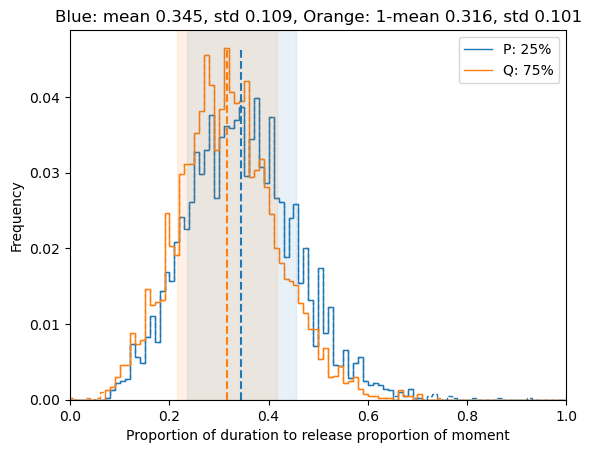

0.2
0.8
0.11176523283755938
0.10209085594353967
0.1727335624422438
0.048015678588927


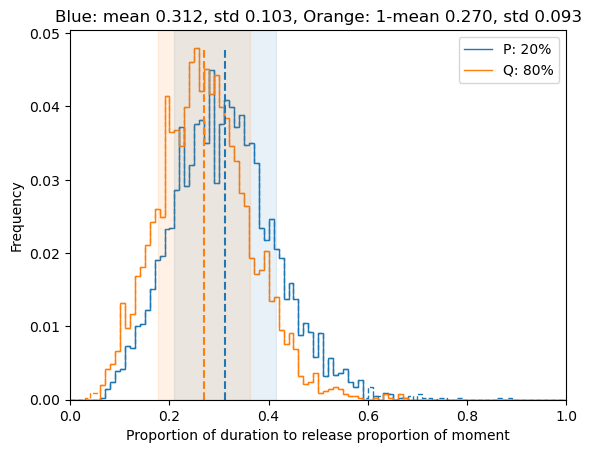

0.15
0.85
0.21294677059360265
0.18908141290603342
0.23938339891660124
0.06565409113179814


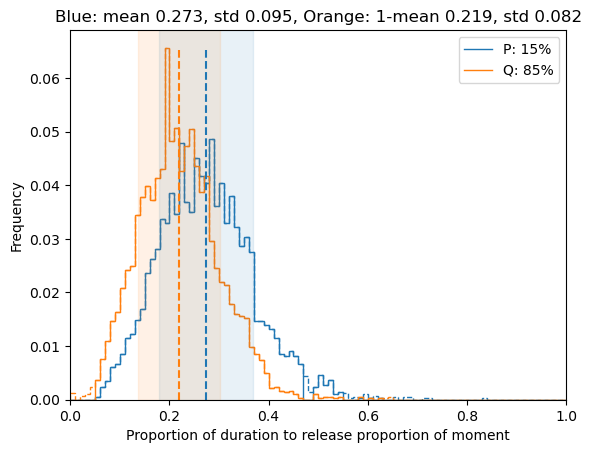

0.1
0.9
0.380324578345067
0.3561605307842734
0.3247417234964712
0.07183133120862957


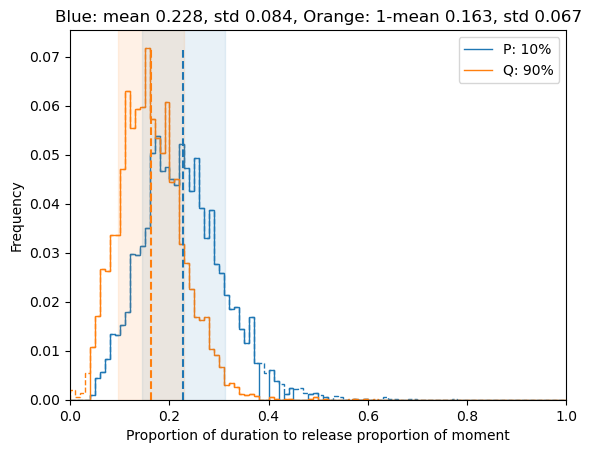

0.05
0.95
0.9566757536634627
0.8204401046625398
0.47909423045374844
0.09845322857844341


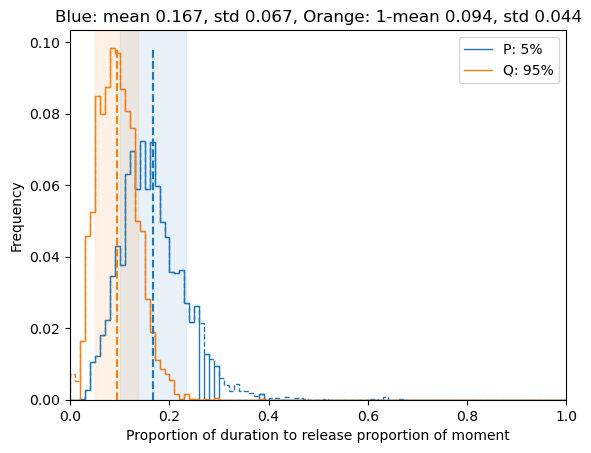

In [13]:
#proportions_list = [0.4, 0.6]
all_proportions = [[0.45, 0.55], [0.4, 0.6], [0.35, 0.65], [0.3, 0.7], [0.25, 0.75], [0.2, 0.8], [0.15, 0.85], [0.1, 0.9], [0.05, 0.95]]
all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []
for proportions_list in all_proportions:
    for proportion in proportions_list:
        print(proportion)
        durations = []
        root_times = []
        relative_root_times = []

        diff = []
        moments = []

        for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
            #print(scardec_name)
            momentrate_opt, time_opt, db = get_stf(scardec_name)

            not_zero = np.where(momentrate_opt > 0)[0]

            dx = time_opt[1]-time_opt[0]

            start = min(not_zero)
            end = max(not_zero)
            points_before_zero = abs(min(time_opt)/dx)

            duration = time_opt[end] - time_opt[start]
            durations.append(duration)

            start_time = time_opt[start]
            end_time = time_opt[end]

            total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
            moments.append(total_moment)
            root, r = scipy.optimize.bisect(f3,
                                            start_time+dx,
                                            end_time,
                                            rtol = 1e-6,
                                            full_output = True,
                                            args = (total_moment,
                                                    time_opt,
                                                    momentrate_opt,
                                                    start,
                                                    points_before_zero,
                                                    proportion,))
            root_idx = np.floor(root/dx)
            root_time = root_idx*dx
            root_times.append(root_time)
            relative_root_times.append(root_time-start_time)

            if root_time-start_time > duration:
                print('root time greater than duration, proportion:', proportion)
                print(scardec_name)

        root_times = np.array(root_times)
        durations = np.array(durations)
        moments = np.log10(np.array(moments))

        rel_root_times = root_times/durations

        n, bins = np.histogram(rel_root_times, bins=np.arange(0, 1.01, 0.01))

        if proportion < 0.5:
            P = n/sum(n)
            #plt.stairs(n/sum(n), bins, label = f'{proportion*100:.0f}%')
        else:
            Q = (n/sum(n))[::-1]
            #plt.stairs((n/sum(n)), bins, label = f'{proportion*100:.0f}%')
            #plt.stairs((n/sum(n))[::-1], bins, label = f'{proportion*100:.0f}%')
        plt.ylabel('Frequency')
        plt.xlabel('Proportion of duration to release proportion of moment')
        plt.xlim(0, 1)

        if proportion < 0.5:
            rel_root_times_1 = rel_root_times
        else:
            rel_root_times_2 = rel_root_times

        if proportion > 0.5:
            tf = (P != 0) & (Q != 0)
            z_p = np.zeros(len(bins)-1)
            z_q = np.zeros(len(bins)-1)
            z_p[tf] = P[tf]
            z_q[tf] = Q[tf]
            plt.stairs(P, bins, linestyle = '--', color = 'tab:blue')
            plt.stairs(Q, bins, linestyle = '--', color = 'tab:orange')
            plt.stairs(z_p, bins, color = 'tab:blue', label = f'P: {myround((1-proportion)*100):.0f}%')
            plt.stairs(z_q, bins, color = 'tab:orange', label = f'Q: {myround(proportion*100):.0f}%')
            KL = sum(rel_entr(P[tf], Q[tf]))
            print(KL)
            KL_2 = sum(rel_entr(Q[tf], P[tf]))
            print(KL_2)
            print(hellinger_explicit(P, Q))

            max_val = max(max(P), max(Q))
            print(max_val)

            plt.vlines(np.mean(rel_root_times_1),
                       0, max_val,
                       color = 'tab:blue', linestyle = '--')
            plt.vlines(1-np.mean(rel_root_times_2),
                       0, max_val,
                       color = 'tab:orange', linestyle = '--')
            plt.axvspan(np.mean(rel_root_times_1)-np.std(rel_root_times_1),
                        np.mean(rel_root_times_1)+np.std(rel_root_times_1),
                        alpha=0.1, color='tab:blue')
            plt.axvspan(1-np.mean(rel_root_times_2)-np.std(rel_root_times_2),
                        1-np.mean(rel_root_times_2)+np.std(rel_root_times_2),
                        alpha=0.1, color='tab:orange')


            plt.title(f'Blue: mean {np.mean(rel_root_times_1):.3f}, std {np.std(rel_root_times_1):.3f}, Orange: 1-mean {1-np.mean(rel_root_times_2):.3f}, std {np.std(rel_root_times_2):.3f}')
            plt.legend()
            plt.show()

    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/flipped_histogram_fraction_of_duration_for_{myround((1-proportion)*100)}_{myround(proportion*100)}_percent_moment_mean_std.png')
    #plt.close()

In [14]:
std_list = []
for _ in range(0, 100):
    random_numbers = np.random.uniform(0, 1, 1000)
    std_list.append(np.std(random_numbers))

(array([ 1.,  0.,  4., 10., 13., 25., 23., 16.,  5.,  3.]),
 array([0.27513975, 0.2774047 , 0.27966965, 0.2819346 , 0.28419955,
        0.2864645 , 0.28872945, 0.2909944 , 0.29325935, 0.2955243 ,
        0.29778925]),
 <BarContainer object of 10 artists>)

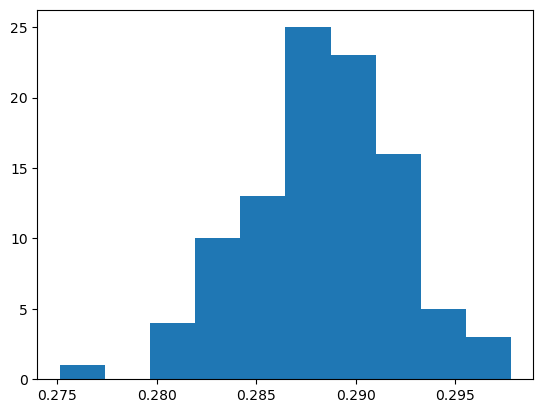

In [15]:
plt.hist(std_list)

In [16]:
np.mean(std_list)

0.2882453185962291

/tmp/ipykernel_2181289/448550963.py:6: RuntimeWarning: invalid value encountered in scalar divide
  H2 = 1 - np.sqrt(2*sigma_1*sigma_2/(sigma_1**2 + sigma_2**2)) * np.exp(-0.25*(mu_1-mu_2)**2/(sigma_1**2 + sigma_2**2))
/tmp/ipykernel_2181289/448550963.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  H2 = 1 - np.sqrt(2*sigma_1*sigma_2/(sigma_1**2 + sigma_2**2)) * np.exp(-0.25*(mu_1-mu_2)**2/(sigma_1**2 + sigma_2**2))
/tmp/ipykernel_2181289/448550963.py:14: RuntimeWarning: invalid value encountered in scalar divide
  H2 = 1 - np.sqrt(2*sigma_1*sigma_2/(sigma_1**2 + sigma_2**2)) * np.exp(-0.25*(mu_1-mu_2)**2/(sigma_1**2 + sigma_2**2))
/tmp/ipykernel_2181289/448550963.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  H2 = 1 - np.sqrt(2*sigma_1*sigma_2/(sigma_1**2 + sigma_2**2)) * np.exp(-0.25*(mu_1-mu_2)**2/(sigma_1**2 + sigma_2**2))


(array([   2900.,    3176.,    7528.,    9668.,   12372.,   14484.,
          17324.,   18636.,   22216.,   23120.,   23542.,   30216.,
          29234.,   32002.,   32770.,   34226.,   35984.,   39002.,
          38874.,   41894.,   41760.,   45068.,   43998.,   50538.,
          44144.,   51386.,   50126.,   47070.,   55306.,   56006.,
          53500.,   47386.,   71456.,   51912.,   62654.,   60062.,
          59482.,   64736.,   65902.,   63506.,   66458.,   66036.,
          68694.,   71464.,   69224.,   68222.,   72006.,   74120.,
          77046.,   74232.,   77426.,   77732.,   76288.,   79070.,
          79944.,   77586.,   86340.,   83866.,   85166.,   84708.,
          88958.,   90330.,   89524.,   86690.,   88608.,   96490.,
          93090.,   91708.,   98606.,   99862.,   97642.,   99030.,
          99406.,  106070.,  104522.,  104902.,  104992.,  107438.,
         111196.,  119196.,  111232.,  106844.,  117290.,  118326.,
         125338.,  131656.,  128936.,  123958., 

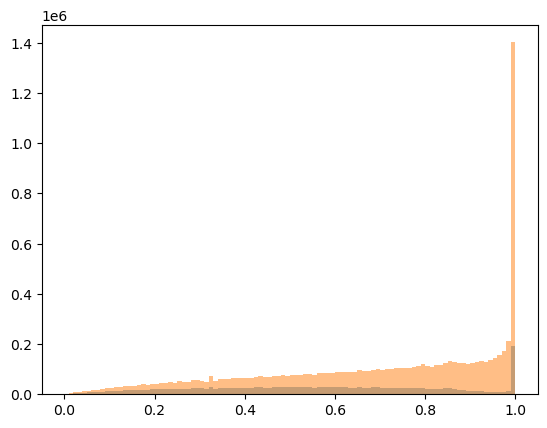

In [17]:
distribution = []
for sigma_1 in np.arange(0, 0.3, 0.01):
    for sigma_2 in np.arange(0, 0.3, 0.01):
        for mu_1 in np.arange(0, 0.5, 0.01):
            for mu_2 in np.arange(0, 0.5, 0.01):
                H2 = 1 - np.sqrt(2*sigma_1*sigma_2/(sigma_1**2 + sigma_2**2)) * np.exp(-0.25*(mu_1-mu_2)**2/(sigma_1**2 + sigma_2**2))
                distribution.append(np.sqrt(H2))
plt.hist(distribution, bins = 100, alpha = 0.5)
distribution = []
for sigma_1 in np.arange(0, 0.3, 0.01):
    for sigma_2 in np.arange(0, 0.3, 0.01):
        for mu_1 in np.arange(0, 1, 0.01):
            for mu_2 in np.arange(0, 1, 0.01):
                H2 = 1 - np.sqrt(2*sigma_1*sigma_2/(sigma_1**2 + sigma_2**2)) * np.exp(-0.25*(mu_1-mu_2)**2/(sigma_1**2 + sigma_2**2))
                distribution.append(np.sqrt(H2))
plt.hist(distribution, bins = 100, alpha = 0.5)

(array([   2900.,    3176.,    7528.,    9668.,   12372.,   14484.,
          17324.,   18636.,   22216.,   23120.,   23542.,   30216.,
          29234.,   32002.,   32770.,   34226.,   35984.,   39002.,
          38874.,   41894.,   41760.,   45068.,   43998.,   50538.,
          44144.,   51386.,   50126.,   47070.,   55306.,   56006.,
          53500.,   47386.,   71456.,   51912.,   62654.,   60062.,
          59482.,   64736.,   65902.,   63506.,   66458.,   66036.,
          68694.,   71464.,   69224.,   68222.,   72006.,   74120.,
          77046.,   74232.,   77426.,   77732.,   76288.,   79070.,
          79944.,   77586.,   86340.,   83866.,   85166.,   84708.,
          88958.,   90330.,   89524.,   86690.,   88608.,   96490.,
          93090.,   91708.,   98606.,   99862.,   97642.,   99030.,
          99406.,  106070.,  104522.,  104902.,  104992.,  107438.,
         111196.,  119196.,  111232.,  106844.,  117290.,  118326.,
         125338.,  131656.,  128936.,  123958., 

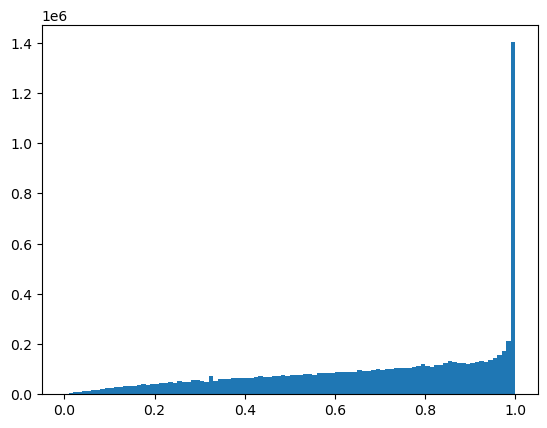

In [18]:
plt.hist(distribution, bins = 100)